## Dictionary learning algorithm to reconstruct images from event data

### Source Code for sklearn : https://github.com/scikit-learn/scikit-learn

In [1]:
from sklearn.feature_extraction import image as image_extractor
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.decomposition import SparseCoder
from skimage import io
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage
import csv
import numpy as np
import distutils
from distutils import util
from scipy import fftpack
import math
import time
#import wavepy
import pandas as pd
import pdb
import pylab as pl
from IPython import display

from sklearn.utils import check_array, check_random_state, gen_even_slices, gen_batches
import itertools

## Help functions

In [2]:
"""
Class inherited from MiniBatchDictionaryLearning() from scikit-learn
For implementation of dictionary visualization while learning
"""
class MyMiniBatchDictionaryLearning(MiniBatchDictionaryLearning):
    def fit(self, X, y=None):
        """Fit the model from data in X.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training vector, where `n_samples` is the number of samples
            and `n_features` is the number of features.
        y : Ignored
            Not used, present for API consistency by convention.
        Returns
        -------
        self : object
            Returns the instance itself.
        """
        
        pl.figure(figsize=(4.2, 4))
        self.diff_dict = []
        
        self._batch_size = self.batch_size
        if self.batch_size == "warn":
            warnings.warn(
                "The default value of batch_size will change from 3 to 256 in 1.3.",
                FutureWarning,
            )
            self._batch_size = 3

        X = self._validate_data(
            X, dtype=[np.float64, np.float32], order="C", copy=False
        )

        self._check_params(X)
        self._random_state = check_random_state(self.random_state)

        dictionary = self._initialize_dict(X, self._random_state)
        old_dict = dictionary.copy()

        if self.shuffle:
            X_train = X.copy()
            self._random_state.shuffle(X_train)
        else:
            X_train = X

        n_samples, n_features = X_train.shape

        if self.verbose:
            print("[dict_learning]")

        # Inner stats
        self._inner_stats = (
            np.zeros((self._n_components, self._n_components), dtype=X_train.dtype),
            np.zeros((n_features, self._n_components), dtype=X_train.dtype),
        )

        if self.max_iter is not None:

            # Attributes to monitor the convergence
            self._ewa_cost = None
            self._ewa_cost_min = None
            self._no_improvement = 0

            batches = gen_batches(n_samples, self._batch_size)
            batches = itertools.cycle(batches)
            n_steps_per_iter = int(np.ceil(n_samples / self._batch_size))
            n_steps = self.max_iter * n_steps_per_iter

            i = -1  # to allow max_iter = 0

            for i, batch in zip(range(n_steps), batches):
                X_batch = X_train[batch]

                batch_cost = self._minibatch_step(
                    X_batch, dictionary, self._random_state, i
                )

                if self._check_convergence(
                    X_batch, batch_cost, dictionary, old_dict, n_samples, i, n_steps
                ):
                    break

                # XXX callback param added for backward compat in #18975 but a common
                # unified callback API should be preferred
                if self.callback is not None:
                    self.callback(locals())
                
                self.diff_dict.append(np.linalg.norm(dictionary - old_dict, 'fro'))
                
                # plot the dictionary
                if ((i < plot_stop_at_x_dicts) and (i%plot_period == 0 or (i%plot_period_beginning == 0 and i < plot_steps_beginning))):
                    plot_dict(dictionary.copy(), i, num_atoms_plot, patch_size[0])
                    print("step",i,", difference between dicts:", self.diff_dict[-1])
                elif progress_verbose and i%20 == 0:
                    print("step",i,", difference between dicts:", self.diff_dict[-1])
                    
                if i == plot_stop_at_x_dicts:
                    print("Halted plotting because plot_stop_at_x_dicts is set to " + str(plot_stop_at_x_dicts))
                
                old_dict[:] = dictionary
                
            self.n_steps_ = i + 1
            self.n_iter_ = np.ceil(self.n_steps_ / n_steps_per_iter)
        else:
            # TODO remove this branch in 1.3
            if self.n_iter != "deprecated":
                warnings.warn(
                    "'n_iter' is deprecated in version 1.1 and will be removed"
                    " in version 1.3. Use 'max_iter' instead.",
                    FutureWarning,
                )
                n_iter = self.n_iter
            else:
                n_iter = 1000

            batches = gen_batches(n_samples, self._batch_size)
            batches = itertools.cycle(batches)

            for i, batch in zip(range(n_iter), batches):
                self._minibatch_step(X_train[batch], dictionary, self._random_state, i)

                trigger_verbose = self.verbose and i % ceil(100.0 / self.verbose) == 0
                if self.verbose > 10 or trigger_verbose:
                    print(f"{i} batches processed.")

                if self.callback is not None:
                    self.callback(locals())
                
                # plot the dictionary
                plot_dict(dictionary.copy(), i, num_atoms_plot, patch_size[0])

            self.n_steps_ = n_iter
            self.n_iter_ = np.ceil(n_iter / int(np.ceil(n_samples / self._batch_size)))

        self.components_ = dictionary

        return self

In [4]:
"""
First order discretization (linear voting in time)
    events in t,x,y,pol  numpy array
    Assume x and y are integer coordinates
    img_size: for example (180,240) for the DAVIS240C
    num_time_slices: 3-9, for example, 5
"""
def events2voxelgrid_linear_event_utils(x, y, timestamp, pol, img_size, num_time_slices, t_min, dt_cell, use_polarity=True):
    import sys, os
    if __package__:
        from .. import image
    else:
        sys.path.append(os.getcwd() + '/..')
        #os.getcwd()
        import image
    
    pol_real=[(2*pol_el - 1) for pol_el in pol]

    # xs, ys, ts, ps are all torch sensors
    import torch
    xs = torch.tensor(x)
    ys = torch.tensor(y)
    ts = torch.tensor(timestamp)
    ps = torch.tensor(pol_real)
    
    # from event_utils/lib/representations/voxel_grid.py
    bins = []
    dt = ts[-1]-ts[0] # produces array
    t_norm = (ts-ts[0])/dt*(num_time_slices-1)
    zeros = (np.expand_dims(np.zeros(t_norm.shape[0]), axis=0).transpose()).squeeze()
    for bi in range(num_time_slices):
        bilinear_weights = np.maximum(zeros, 1.0-np.abs(t_norm-bi))
        weights = ps*bilinear_weights
        vb = image.events_to_image(xs.squeeze(), ys.squeeze(), weights.squeeze(),
                sensor_size=sensor_size, interpolation=None)            
        bins.append(vb)
        
    bins = np.stack(bins)    
    bins_sorted = np.swapaxes(np.swapaxes(bins, 0, 1), 1, 2)    
    return bins_sorted

In [3]:
"""
First order discretization (linear voting in time)
    events in t,x,y,pol  numpy array
    Assume x and y are integer coordinates
    img_size: for example (180,240) for the DAVIS240C
    num_time_slices: 3-9, for example, 5
"""
def events2voxelgrid_linear_OUTDATED(x, y, timestamp, pol, img_size, num_bins_t, t_min, dt_cell, use_polarity=True):
    assert len(x) == len(y) == len(pol) == len(timestamp)
    num_events = len(x)
    # creates a (180,240,num_bins_t) matrix to store the num_bins_t event frames
    # each frame will have both positive and negative events
    voxelgrid = np.zeros(img_size+(num_bins_t,), np.float64)
    for i in range(num_events-1):
        tn = (timestamp[i] - t_min) / dt_cell
        ti = int(tn)
        dt = tn - ti
        # Voting on two adjacent cells
        polarity = (2.*pol[i] - 1.) if use_polarity else 1.
        if ti < num_bins_t:
            voxelgrid[y[i], x[i], ti] += (1. - dt)*polarity
        if ti < num_bins_t-1:
            voxelgrid[y[i], x[i], ti+1] += dt*polarity
        if ti > num_bins_t-1:
            print("this time slicing is wrong, because the influence of dt*polarity is completely lost for the end of the event stream \nUse events2voxelgrid_linear_event_utils() instead")
    print(np.sum(np.abs(voxelgrid)))  # This should equal the number of events
    return voxelgrid.astype('float32')

In [5]:
"""
Plot voxel grid as event frames
"""
def plotVoxelGridZSlices(voxelgrid, name='voxelgrid'):
    vmin = voxelgrid.min()
    vmax = voxelgrid.max()
    if np.sign(vmin) != 0 and (np.sign(vmin) != np.sign(vmax)):
        # if voxel grid uses polarity
        r_val = np.array([vmin,vmax])
        max_abs_val = np.max( np.abs(r_val) )
        vmin = -max_abs_val
        vmax = max_abs_val
        cmap_val = 'gray'
    else:
        # if voxel grid does not use polarity
        assert vmin >= 0
        cmap_val = 'gray_r'
    
    fig, axs = plt.subplots(int(np.ceil(voxelgrid.shape[2]/2.)), 2, figsize=(15, 15))
    for i in range(voxelgrid.shape[2]):
        plt.sca(axs[int(i/2),i%2])
        plt.imshow(voxelgrid[:,:,i], cmap=cmap_val, vmin=vmin, vmax=vmax)
        plt.xticks([])
        plt.yticks([])
        plt.colorbar()
        
    if voxelgrid.shape[2] % 2 != 0:
        axs.flat[-1].set_visible(False)
    plt.show()
    
    
# save the figures in the correct size (to check edge velocity)
    print("The image below is only for saving the images in the correct image size.")
    px = 1/plt.rcParams['figure.dpi']  # pixel in inches
    
    fig2 = plt.figure(figsize=(240*px, 180*px)) # image_size = (180, 240) # [CHANGE BACK TO 180 AND 240]
    #ax2.axis('off')
    ax = plt.Axes(fig2, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig2.add_axes(ax)
    for i in range(voxelgrid.shape[2]):
        ax.imshow(voxelgrid[:,:,i], cmap=cmap_val, vmin=vmin, vmax=vmax, aspect='auto')
        fig2.savefig(name+str(i)+'.png')

In [6]:
"""
Plot voxel grid as event frames, but as one column
"""
def plotVoxelGridZSlicesAsOneColumn(voxelgrid):
    vmin = voxelgrid.min()
    vmax = voxelgrid.max()
    if np.sign(vmin) != 0 and (np.sign(vmin) != np.sign(vmax)):
        # if voxel grid uses polarity
        r_val = np.array([vmin,vmax])
        max_abs_val = np.max( np.abs(r_val) )
        vmin = -max_abs_val
        vmax = max_abs_val
        cmap_val = 'gray'
    else:
        # if voxel grid does not use polarity
        assert vmin >= 0
        cmap_val = 'gray_r'
    
    fig, axs = plt.subplots(voxelgrid.shape[2],1, figsize=(5, 25))
    for i in range(voxelgrid.shape[2]):
        plt.sca(axs[i])
        plt.imshow(voxelgrid[:,:,i], cmap=cmap_val, vmin=vmin, vmax=vmax)
        plt.xticks([])
        plt.yticks([])
        plt.colorbar()
    plt.show()

In [7]:
"""
Plot learned dictionary
"""
def plot_dict(dicti, step, num_atoms_plot, patch_size):
    for i, comp in enumerate(dicti[:num_atoms_plot]):
        pl.subplot(int(num_atoms_plot/10), 10, i + 1)
        atom = comp.reshape(patch_size,patch_size,-1)
        pl.imshow(atom[:,:,0], cmap=pl.cm.gray_r,
               interpolation='nearest')
        pl.xticks(())
        pl.yticks(())
    pl.suptitle('Dictionary learned. step'+str(step)+'. Gx\n', fontsize=16)
    pl.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
    
    display.clear_output(wait=True) # wait=True doesn't clear the output until new output is available to replace it
    display.display(pl.gcf()) # get current figure (if there is none, one is created)
    #time.sleep(0.15)

### Parameters of the method

In [8]:
simulated_data = True

patch_size = (7,7)
max_patches = 80000  # Due to memory issues # before was 80000

# dictionary plotting parameters
num_atoms_plot = 40
plot_period = 180
plot_period_beginning = 1 # if plot_period == 1, then this is effectless
plot_steps_beginning = 20 # plots every one of the first x dicts, afterwards like plot_period states
plot_stop_at_x_dicts = 50000 # stops plotting after x plotted dicts # put eg 50000 if all dicts should be plotted
progress_verbose = True

# Event parameters: the number of events to be taken into consideration
num_time_slices = 7

# Method to compute voxel grids of events (time slices): nearest neighbor or linear voting
method_voting = 'Linear'
sensor_size = (180,240)

# Split by polarity (double grid size) or not?
split_by_polarity = False

# Atom size (determined by above parameters)
atom_size = patch_size[0]*patch_size[1] * (2 + num_time_slices * (2 if split_by_polarity else 1))
print('Num dims of an atom = ' + str(atom_size))

# Dictionary
num_elem_grads = 2*patch_size[0]*patch_size[1]
n_components = 4*(atom_size - num_elem_grads)
print('Num atoms in dictionary = ' + str(n_components))

# Scale factor to balance the energy of the derivatives and the events
C_scale = 100.

pruning = True
n_coefs_transform = 3 # originally was 3

# Should use log scale instead of linear scale...

Num dims of an atom = 441
Num atoms in dictionary = 1372


### Read the image

In [9]:
image = io.imread("frame_berlinale_00000024.png",as_gray=True).astype('float32')

Load as grayscale image (because we know that the image has no color), and also convert to floating point, to operate on real numbers, not on integers.

In [10]:
image.shape

(180, 240)

In [11]:
image.dtype

dtype('float32')

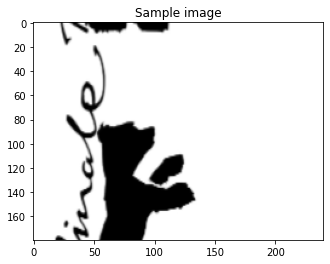

In [12]:
plt.imshow(image, cmap='gray')
plt.title('Sample image')
plt.show()

### Calculate the X and Y derivative using sobel operator. This is very good with edge detection

In [13]:
image_x = ndimage.sobel(image, axis=0).astype('float32') / C_scale
image_y = ndimage.sobel(image, axis=1).astype('float32') / C_scale

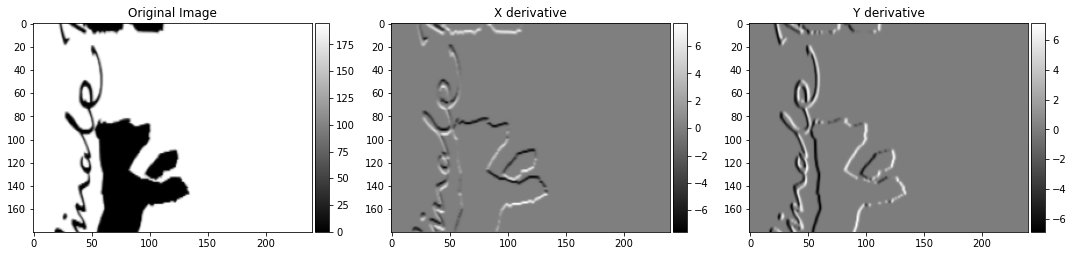

In [14]:
fig, (ax1,ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5), sharex = True)

p1 = ax1.imshow(image, cmap='gray')
ax1.set_title('Original Image')
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(p1, cax=cax)

p2 = ax2.imshow(image_x, cmap='gray')
ax2.set_title('X derivative')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(p2, cax=cax)

p3 = ax3.imshow(image_y, cmap='gray')
ax3.set_title('Y derivative')
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(p3, cax=cax)
fig.tight_layout(pad=1.0)
plt.show()

## Create the event histogram

Read events

In [15]:
# read the file and store it in different arrays 
timestamp = []
x = []
y = []
pol = []

if simulated_data:
    import pickle
    with open("sim_berlinale_short48.pkl", "rb") as pklfile: # an example of simulated data with very low edge velocity of 2 pix/seq
        loaded_events = pickle.load(pklfile)
        x = loaded_events['x']
        y = loaded_events['y']
        timestamp = loaded_events['timestamp']
        pol = loaded_events['pol']
            
else:
    with open('event_data12102020_middlehalf.csv') as csvfile:
        event_file = csv.reader(csvfile, delimiter=',')
        next(event_file)
        for row in event_file:
            if len(row) == 0:
                continue; # while writing, an additional alternative empty row is written in the excel. so skippping
            x.append(int(float(row[0])))
            y.append(int(float(row[1])))
            timestamp.append(float(row[2]))
            #pol.append(distutils.util.strtobool(row[3]))
            pol.append(int(float(row[3])))
        
assert len(x) == len(y) == len(pol) == len(timestamp)

In [16]:
total_num_events = len(x)

In [17]:
total_num_events

16400

In [18]:
# convert to arrays
x = np.array(x)
y = np.array(y)
timestamp = np.array(timestamp)
pol = np.array(pol)

In [19]:
##### Divide the events into chunks of equal time span $\Delta t$, rather than equal number of events    
t_max = np.amax(timestamp)
t_min = np.amin(timestamp)
t_range = t_max - t_min
dt_cell = t_range / num_time_slices
t_edges = np.linspace(t_min,t_max,num_time_slices+1) # boundaries of the cells; not needed
print(t_min,t_max,t_range,dt_cell)

# Specify bin edges in each dimension
bin_edges = (np.linspace(0,image.shape[0],image.shape[0]+1), 
             np.linspace(0,image.shape[1],image.shape[1]+1), t_edges)

9.38313299 9.487008484 0.1038754940000004 0.014839356285714343


Interpolated histogram
(180, 240, 7)


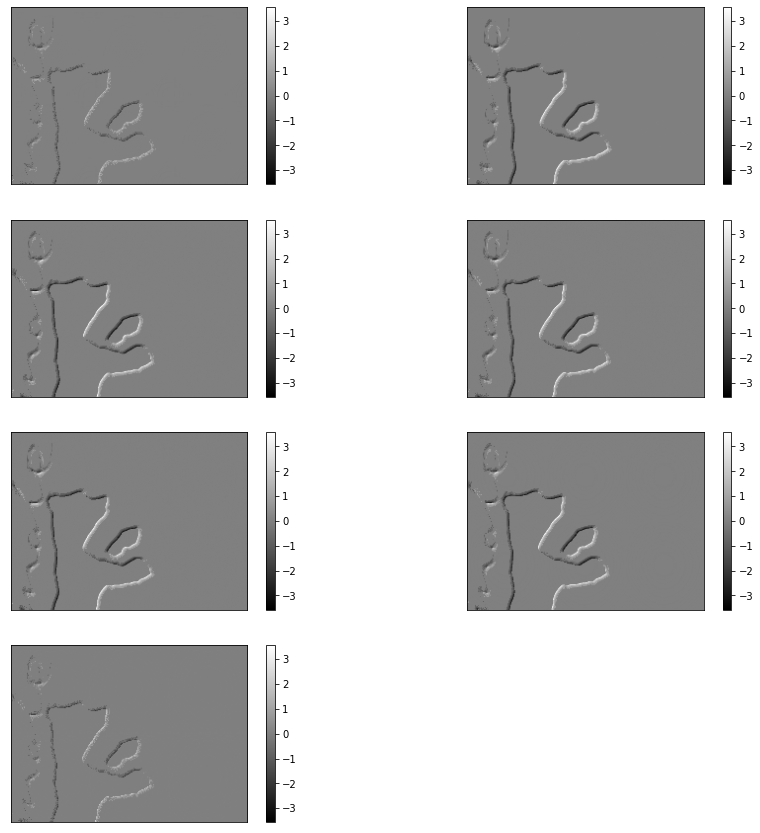

The image below is only for saving the images in the correct image size.


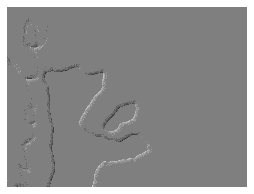

In [20]:
if not split_by_polarity:
    # one voxel grid for all events (both polarities)
    if (method_voting == 'nearest'):
        print('Regular histogram')
        yxt = np.transpose(np.array([y, x, timestamp]))
        voxelgrid, _ = np.histogramdd(yxt, bins=bin_edges).astype('float32')
        del yxt
    else:
        print('Interpolated histogram')
        voxelgrid = events2voxelgrid_linear_event_utils(x,y,timestamp,pol, 
                                            image.shape,num_time_slices,t_min,dt_cell,use_polarity=True)
    print(voxelgrid.shape)
    plotVoxelGridZSlices(voxelgrid, name='voxelgrid_pos_and_neg')
    #plotVoxelGridZSlicesAsOneColumn(voxelgrid)

In [21]:
if split_by_polarity:
    # Positive events only
    idx_pos = pol==0

    if (method_voting == 'nearest'):
        print('Regular histogram')
        yxt_pos = np.transpose(np.array([y[idx_pos], x[idx_pos], timestamp[idx_pos]]))
        voxelgrid_pos, _ = np.histogramdd(yxt_pos, bins=bin_edges).astype('float32')
        del yxt_pos
    else:
        print('Interpolated histogram')
        voxelgrid_pos = events2voxelgrid_linear_event_utils(x[idx_pos],y[idx_pos],timestamp[idx_pos],pol[idx_pos], 
                                                image.shape,num_time_slices,t_min,dt_cell,use_polarity=False)
    print(voxelgrid_pos.shape)
    plotVoxelGridZSlices(voxelgrid_pos, name='voxelgrid_pos')
    #plotVoxelGridZSlicesAsOneColumn(voxelgrid_pos)

In [22]:
if split_by_polarity:
    # Negative events only
    idx_neg = pol!=0

    if (method_voting == 'nearest'):
        print('Regular histogram')
        yxt_neg = np.transpose(np.array([y[idx_neg], x[idx_neg], timestamp[idx_neg]]))
        voxelgrid_neg, _ = np.histogramdd(yxt_neg, bins=bin_edges).astype('float32')
        del yxt_neg
    else:
        print('Interpolated histogram')
        voxelgrid_neg = events2voxelgrid_linear_event_utils(x[idx_neg],y[idx_neg],timestamp[idx_neg],pol[idx_neg], 
                                                image.shape,num_time_slices,t_min,dt_cell,use_polarity=False)
    print(voxelgrid_neg.shape)
    plotVoxelGridZSlices(voxelgrid_neg, name='voxelgrid_neg')
    #plotVoxelGridZSlicesAsOneColumn(voxelgrid_neg)

### Combine spatial gradient and temporal derivative (events) to create training patches

Stack the spatial gradient and the temporal derivative (events) on a single WxHxZ array to select the patches together on all Z slices with one single call to `extract_patches_2d`. As we have 5 events and 2 gradients. Z will be 7. W and H will be the image dimension. 

In [23]:
image_gradient = np.concatenate((np.expand_dims(image_x, axis=2), np.expand_dims(image_y, axis=2)), axis=2)
print(image_gradient.shape)
if split_by_polarity:
    voxelgrid = np.concatenate((voxelgrid_pos,voxelgrid_neg), axis=2)
data = np.concatenate((image_gradient, voxelgrid), axis=2)
del image_gradient

(180, 240, 2)


In [24]:
data.shape

(180, 240, 9)

In [25]:
data.dtype

dtype('float64')

In [26]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.image.extract_patches_2d.html
# source code : https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/feature_extraction/image.py
data_patches = image_extractor.extract_patches_2d(data, patch_size, max_patches=max_patches)
data_patches.shape

(40716, 7, 7, 9)

Till here we have extracted all the patches from the 7 layers 

In [27]:
# Plot the information of this patch:
idx_patch = 31

nrm_large = 0
for i in range(int(max_patches/5)):
    # why do this step ?
    ww = data_patches[i].reshape(patch_size[0],patch_size[1],-1)
    nrm = np.linalg.norm(ww)
    if nrm > nrm_large:
        nrm_large = nrm
        idx_patch = i

print(idx_patch)
print(nrm_large)

3949
36.380023704606046


(7, 7, 9)


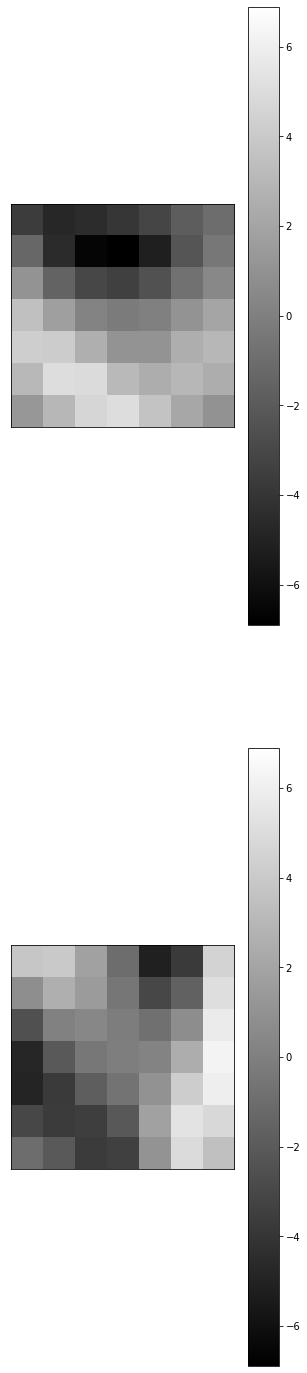

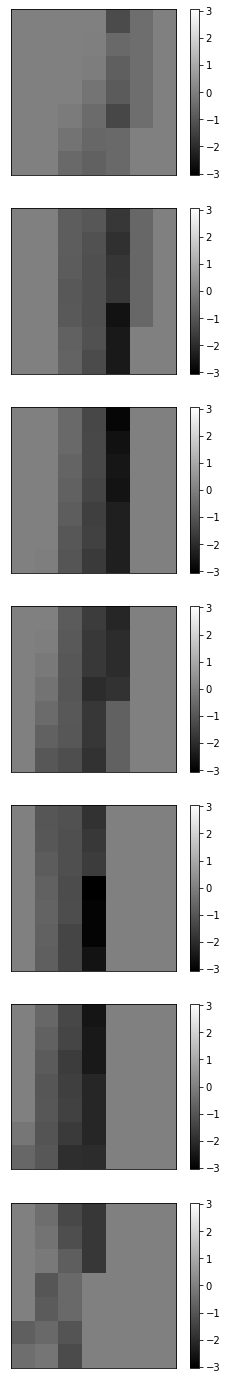

In [28]:
ww = data_patches[idx_patch].reshape(patch_size[0],patch_size[1],-1)
print( ww.shape )
#plotVoxelGridZSlicesAsOneColumn(ww) # Masking effect by unbalanced orders of magnitude
plotVoxelGridZSlicesAsOneColumn(ww[:,:,0:2])
if split_by_polarity:
    plotVoxelGridZSlicesAsOneColumn(ww[:,:,2:2+num_time_slices]) # positive events
    plotVoxelGridZSlicesAsOneColumn(ww[:,:,2+num_time_slices:]) # negative events
else:
    plotVoxelGridZSlicesAsOneColumn(ww[:,:,2:]) # events of both polarities

Prepare (reshape) data for call to dictionary learning function

In [29]:
data_patches = data_patches.reshape(data_patches.shape[0], -1)
data_patches.shape

(40716, 441)

In [30]:
data_patches.dtype

dtype('float64')

Prune patches with low energy

In [31]:
nrm_patches = np.zeros((data_patches.shape[0],1))
for i in range(data_patches.shape[0]):
    nrm_patches[i] = np.linalg.norm(data_patches[i,:num_elem_grads])

In [32]:
nrm_patches.mean()

2.1850951480547987

In [33]:
#_ = plt.hist(nrm_patches, bins='auto')
#plt.show()

In [34]:
thr = nrm_patches.mean()+2*nrm_patches.std()
print(thr)

10.914308120651262


In [35]:
#thr = nrm_patches.mean()+2*nrm_patches.std()
thr = nrm_patches.mean()
print(thr)
if pruning:
    data_patches = np.delete(data_patches, np.where( nrm_patches < thr )[0], 0)
data_patches.shape

2.1850951480547987


(9371, 441)

## Learn the patch-based dictionary

In [36]:
# Dictionary learning one-time-preparations
dico = MyMiniBatchDictionaryLearning(n_components=n_components, alpha=1, max_iter=500) # [or try n_iter?]

import warnings
warnings.filterwarnings("ignore", message="The default value of batch_size will change from*")
warnings.filterwarnings("ignore", message="'n_iter' is deprecated in version*")

# Normalization
data_patches -= np.mean(data_patches, axis=0)
data_patches /= np.std(data_patches, axis=0)

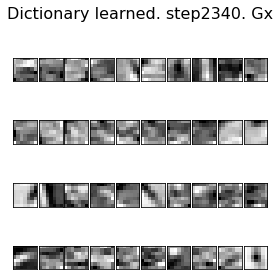

step 2340 , difference between dicts: 3.5620919393747306
step 2360 , difference between dicts: 2.587646595815097
step 2380 , difference between dicts: 1.5904398554314703
1.0 iterations / 2387 steps in 907.86.


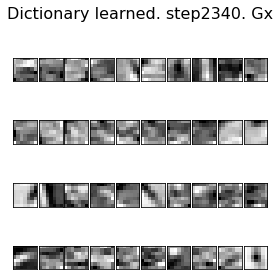

In [37]:
# Actual learning
print('Learning the dictionary...')
start_time = time.time()

# Set plot parameters for vizualizing the atoms
if (num_atoms_plot > n_components):
    num_atoms_plot = n_components

V = dico.fit(data_patches).components_

elapsed_time = time.time() - start_time
#print('Elapsed learning time = %.2fs' % elapsed_time)
print(f"{dico.n_iter_} iterations / {dico.n_steps_} steps in {elapsed_time:.2f}.")
#print(V.shape)
#print(V.dtype)
#dico.get_params()

In [38]:
print(V.dtype)
dico.get_params()

float64


{'alpha': 1,
 'batch_size': 'warn',
 'callback': None,
 'dict_init': None,
 'fit_algorithm': 'lars',
 'max_iter': 500,
 'max_no_improvement': 10,
 'n_components': 1372,
 'n_iter': 'deprecated',
 'n_jobs': None,
 'positive_code': False,
 'positive_dict': False,
 'random_state': None,
 'shuffle': True,
 'split_sign': False,
 'tol': 0.001,
 'transform_algorithm': 'omp',
 'transform_alpha': None,
 'transform_max_iter': 1000,
 'transform_n_nonzero_coefs': None,
 'verbose': False}

### Plot the convergence of the learning phase

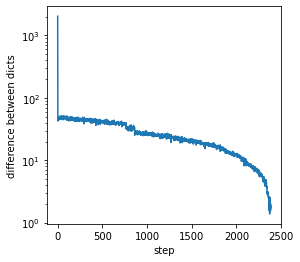

In [39]:
# plot convergence
plt.figure(figsize=(4.2, 4))
plt.semilogy(np.array(dico.diff_dict))
plt.xlabel('step')
plt.ylabel('difference between dicts')
plt.show()

Visualize the atoms:

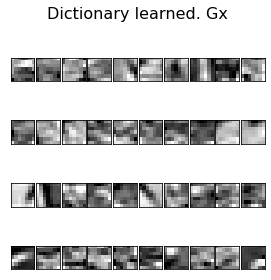

In [40]:
num_atoms_plot = 40
if (num_atoms_plot > n_components):
    num_atoms_plot = n_components

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V[:num_atoms_plot]):
    plt.subplot(int(num_atoms_plot/10), 10, i + 1)
    atom = comp.reshape(patch_size[0],patch_size[0],-1)
    plt.imshow(atom[:,:,0], cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary learned. Gx\n', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

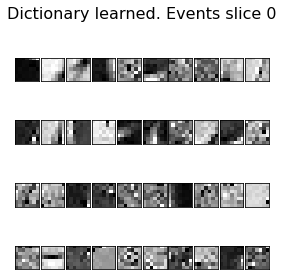

In [41]:
plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V[:num_atoms_plot]):
    plt.subplot(int(num_atoms_plot/10), 10, i + 1)
    atom = comp.reshape(patch_size[0],patch_size[0],-1)
    plt.imshow(atom[:,:,2], cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary learned. Events slice 0\n', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

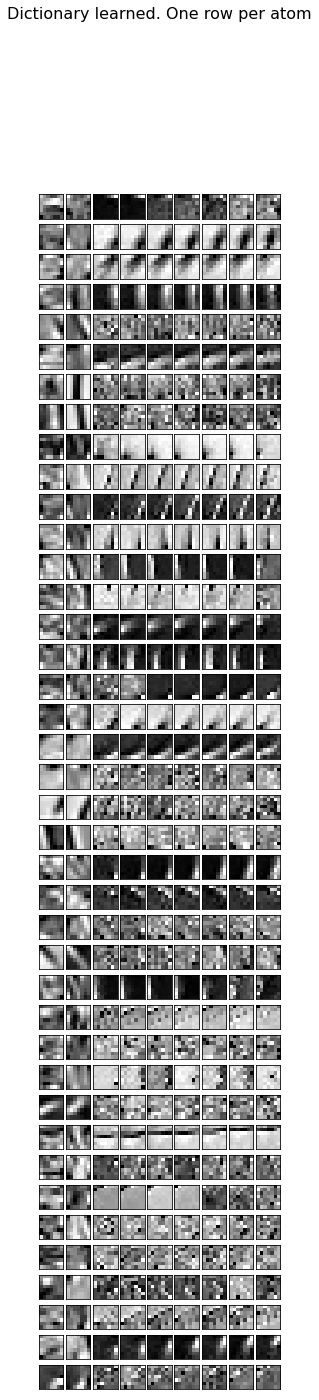

In [42]:
plt.figure(figsize=(4,num_atoms_plot*0.5))
for i, comp in enumerate(V[:num_atoms_plot]):
    atom = comp.reshape(patch_size[0],patch_size[0],-1)
    for j in range(data.shape[2]):
        plt.subplot(num_atoms_plot, data.shape[2], data.shape[2]*i + j + 1)
        plt.imshow(atom[:,:,j], cmap=plt.cm.gray_r, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
plt.suptitle('Dictionary learned. One row per atom\n', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

Dg: Part of the dictionary corresponding to the spatial gradients (the upper part of V)

In [43]:
V_gradients = V[:,:num_elem_grads]
V_gradients.shape

(1372, 98)

De: Part of the dictionary corresponding to the events (the bottom part of V)

In [44]:
V_events = V[:,num_elem_grads:]
V_events.shape

(1372, 343)

In [45]:
dico

MyMiniBatchDictionaryLearning(max_iter=500, n_components=1372)

## Reconstruct image gradients from events by deriving code from the dictionary

In [46]:
data_test = image_extractor.extract_patches_2d(voxelgrid, patch_size)
data_test.shape

(40716, 7, 7, 7)

In [47]:
data_test = data_test.reshape(data_test.shape[0], -1)
intercept = np.mean(data_test, axis=0)
print(intercept.shape)
data_test -= intercept
data_test.shape

(343,)


(40716, 343)

In [48]:
#n_coefs_transform = 13 # originally was 3
coder = SparseCoder(dictionary=V_events, transform_algorithm='omp', transform_n_nonzero_coefs=n_coefs_transform)
#coder = SparseCoder(dictionary=V_events, transform_algorithm='omp')

In [49]:
np.transpose(data_test).shape

(343, 40716)

In [50]:
start_time = time.time()
code = coder.transform(data_test)
elapsed_time = time.time() - start_time
print('Elapsed time = %.2fs' % elapsed_time)

Elapsed time = 51.09s


In [51]:
code.shape

(40716, 1372)

In [52]:
patches_g = np.dot(code, V_gradients)
patches_g.shape

(40716, 98)

In [53]:
patches_g = patches_g.reshape(patches_g.shape[0],patch_size[0],patch_size[1],2)
patches_g.shape

(40716, 7, 7, 2)

In [54]:
reconstruction = image_extractor.reconstruct_from_patches_2d(patches_g, (image.shape[0],image.shape[1],2))
reconstruction.shape

(180, 240, 2)

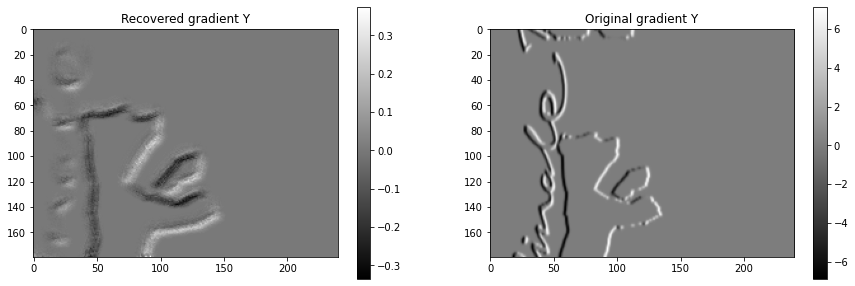

In [55]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (15, 5), sharex = True)

plt.sca(ax1)
plt.imshow(reconstruction[:,:,1], cmap='gray')
plt.colorbar()
plt.title('Recovered gradient Y')

plt.sca(ax2)
plt.imshow(image_y, cmap='gray')
plt.colorbar()
plt.title('Original gradient Y')
plt.show()

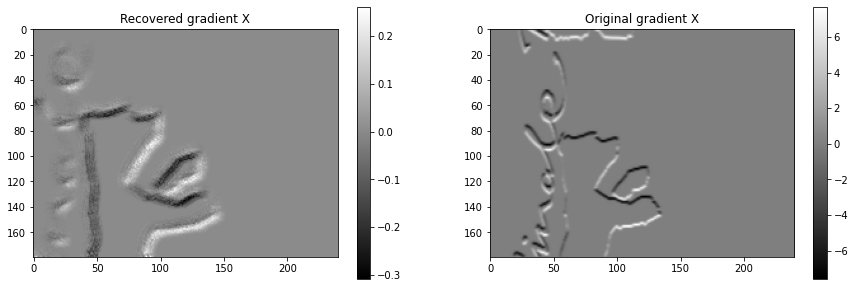

In [56]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (15, 5), sharex = True)

plt.sca(ax1)
plt.imshow(reconstruction[:,:,0], cmap='gray')
plt.colorbar()
plt.title('Recovered gradient X')

plt.sca(ax2)
plt.imshow(image_x, cmap='gray')
plt.colorbar()
plt.title('Original gradient X')
plt.show()

In [57]:
print("Recovered gradient x")
smallest = np.amin(reconstruction[:,:,0])
biggest = np.amax(reconstruction[:,:,0])
print("smallest value",smallest)
print("biggest value",biggest)

print("Recovered gradient y")
smallest = np.amin(reconstruction[:,:,1])
biggest = np.amax(reconstruction[:,:,1])
print("smallest value",smallest)
print("biggest value",biggest)

print("Original gradient x")
smallest = np.min(image_x)
biggest = np.max(image_x)
print("smallest value",smallest)
print("biggest value",biggest)


print("Original gradient y")
smallest = np.min(image_y)
biggest = np.max(image_y)
print("smallest value",smallest)
("biggest value",biggest)

Recovered gradient x
smallest value -0.3081685480022514
biggest value 0.2608713227258924
Recovered gradient y
smallest value -0.33516640502410217
biggest value 0.3740582863839326
Original gradient x
smallest value -7.58
biggest value 7.69
Original gradient y
smallest value -6.89


('biggest value', 7.15)

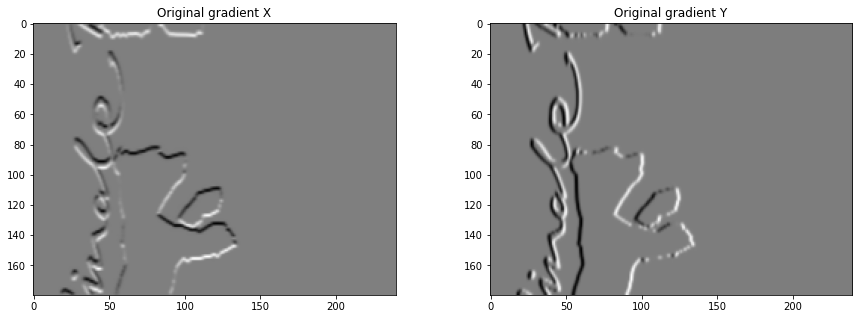

In [58]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (15, 5), sharex = True)

plt.sca(ax1)
plt.imshow(image_x, cmap='gray')
plt.title('Original gradient X')

plt.sca(ax2)
plt.imshow(image_y, cmap='gray')
plt.title('Original gradient Y')
plt.show()

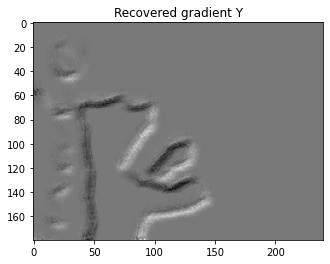

In [59]:
plt.imshow(reconstruction[:,:,1], cmap='gray')
plt.title('Recovered gradient Y')
plt.show()

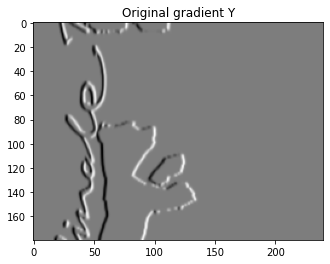

In [60]:
plt.imshow(image_y, cmap='gray')
plt.title('Original gradient Y')
plt.show()